# Simulate a double pendulum system

Refs: 
- https://www.youtube.com/watch?v=tc2ah-KnDXw (Equations of Motion for the Double Pendulum, "Good Vibrations with Freeball").
- https://underactuated.mit.edu/multibody.html#section1

In this notebook, I'll be deriving the equations of motion of a double pendulum. We will then map it to a multivariate first-order system, discretize the dynamics and simulate the evolution.

![](figures/simple_double_pend.svg)

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
IJulia.clear_output();

In [2]:
using DifferentialEquations
using Compose
using Plots
default(label="", grid=false, margin=10Plots.pt)

In [3]:
function polar2cart(z; l1=1, l2=1)
    "Map angles to Cartesian space"

    # Position of first mass
    x1 = l1*sin.(z[1])
    y1 = l1*-cos.(z[1])
    
    # Position of second mass
    x2 = x1 + l2*sin.(z[2])
    y2 = y1 - l2*cos.(z[2])
    
    return (x1,y1), (x2,y2)
end

polar2cart (generic function with 1 method)

## DifferentialEquations solver

There is a SciML blog post on how to simulate a double pendulum system using the DiffEQ.jl suite: https://tutorials.sciml.ai/html/models/01-classical_physics.html. I will use this as a reference.

The equations of motion used are:

$$\begin{align}
    \ddot{\theta}_1 &= - \frac{G(2m_1 + m_2)\sin(\theta_1) + m_2\Big(G\sin(\theta_1 - 2\theta_2) + 2\big(l_2 \dot{\theta}_2^2 + l_1 \dot{\theta}_1^2 \cos(\theta_1 - \theta_2)\big) \sin(\theta_1-\theta_2) \Big)}{2l_1 \big(m_1+m_2-m_2\cos(\theta_1-\theta_2)^2\big)} \\
    \ddot{\theta}_2 &= - \frac{\Big( \big(m_1 + m_2\big) \big(l_1 \dot{\theta}_1^2 + G \cos(\theta_1)\big) + l_2 m_2 \dot{\theta}_2^2 \cos(\theta_1 - \theta_2)\Big) \sin(\theta_1 - \theta_2)}{l_2 \big(m_1 + m_2 - m_2*\cos(\theta_1 - \theta_2)^2\big)} \\
\end{align}$$

In [4]:
# Constants and setup
const g = 9.81
const m₁, m₂, L₁, L₂ = 1, 2, 1, 2
initial = [0, π/3, 0, 3π/5]
tspan = (0.,100.)
dt = 0.1

# Define the Problem
function double_pendulum(xdot,x,p,t)
    xdot[1] = x[2]
    xdot[2] = -((g*(2*m₁+m₂)*sin(x[1])+m₂*(g*sin(x[1]-2*x[3])+2*(L₂*x[4]^2+L₁*x[2]^2*cos(x[1]-x[3]))*sin(x[1]-x[3])))/(2*L₁*(m₁+m₂-m₂*cos(x[1]-x[3])^2)))
    xdot[3] = x[4]
    xdot[4] = (((m₁+m₂)*(L₁*x[2]^2+g*cos(x[1]))+L₂*m₂*x[4]^2*cos(x[1]-x[3]))*sin(x[1]-x[3]))/(L₂*(m₁+m₂-m₂*cos(x[1]-x[3])^2))
end

# Pass to Solvers
double_pendulum_problem = ODEProblem(double_pendulum, initial, tspan)
sol = solve(double_pendulum_problem, Vern7(), dt=dt);

In [17]:
time = tspan[1]:dt:tspan[end]
T = length(time)

1001

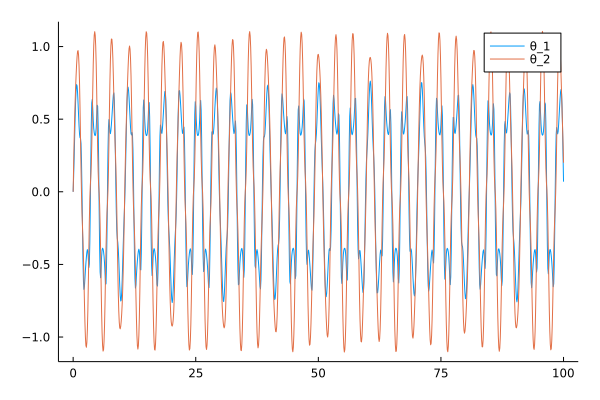

In [18]:
sim_z = cat(sol.(time)..., dims=2)
plot(u, sim_z[1,:], label="θ_1")
plot!(u, sim_z[3,:], label="θ_2")

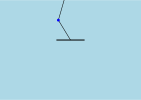

In [23]:
for (ii,t) in enumerate(time)
    
    # Clear frame
    IJulia.clear_output(true)
    
    # Define mass size
    bob_size = 0.05
    
    # Extract Cartesian positions
    p1, p2 = polar2cart(sim_z[[1,3],ii], l1=L₁, l2=L₂)

    nodes = []
    
    # root node: background
    push!(nodes, (context(units=UnitBox(-2, -2, 5, 5))), Compose.rectangle(), fill("lightblue"))
    
    # top line: ceiling
    push!(nodes, (context(), line([(0,0), (1,0)]), Compose.stroke("black"), linewidth(1mm)))

    for p in [p1, p2]
        # pendulum ball
        push!(nodes, (context(), Compose.circle(p[1], p[2], m1*bob_size), fill("blue")))
    end
    
    # pendulum thread
    push!(nodes, (context(), line([(0.5,0.0),(p1[1],p1[2])]), Compose.stroke("black"), linewidth(0.5mm)))
    push!(nodes, (context(), line([(p1[1],p1[2]),(p2[1],p2[2])]), Compose.stroke("black"), linewidth(0.5mm)))
    ctx = compose(nodes...)
    display(ctx)
    
end

## Manual simulation

Using Lagrangian mechanics, we obtain the following equations of motion:

$$\begin{align} 
(m_1 + m_2)l_1\ddot{\theta}_1 + m_2 l_2 \ddot{\theta}_2 \cos(\theta_1 - \theta_2) + m_2 l_2 \dot{\theta}_2^2 \sin(\theta_1 - \theta_2) + (m_1 + m_2)G \sin(\theta_1) &= 0 \\
m_2 l_2 \ddot{\theta}_2 + m_2 l_1 \ddot{\theta}_1 \cos(\theta_1 - \theta_2) - m_2 l_1 \dot{\theta}_1^2 \sin(\theta_1 - \theta_2) + m_2 G \sin(\theta_2) &= 0
\end{align}$$

We'd like to isolate the second-order derivates on one side:

$$\begin{align} 
(m_1 + m_2)l_1\ddot{\theta}_1 + m_2 l_2 \ddot{\theta}_2 \cos(\theta_1 - \theta_2) &= - m_2 l_2 \dot{\theta}_2^2 \sin(\theta_1 - \theta_2) - (m_1 + m_2)G \sin(\theta_1) \\
m_2 l_1 \ddot{\theta}_1 \cos(\theta_1 - \theta_2) + m_2 l_2 \ddot{\theta}_2&= m_2 l_1 \dot{\theta}_1^2 \sin(\theta_1 - \theta_2) - m_2 G \sin(\theta_2)
\end{align}$$

By introducing the matrix 

$$M(\theta_1,\theta_2) = \begin{bmatrix} (m_1+m_2)l_1 & m_2l_2\cos(\theta_1-\theta_2) \\ m_2l_1\cos(\theta_1-\theta_2) & m_2l_2 \end{bmatrix} \, ,$$ 

we can formulate the left-hand side as a matrix-vector product:

$$\begin{align} 
\begin{bmatrix} (m_1+m_2)l_1 & m_2l_2\cos(\theta_1-\theta_2) \\ m_2l_1\cos(\theta_1-\theta_2) & m_2l_2 \end{bmatrix} \begin{bmatrix} \ddot{\theta}_1 \\ \ddot{\theta}_2 \end{bmatrix} = \begin{bmatrix} - m_2 l_2 \dot{\theta}_2^2 \sin(\theta_1 - \theta_2) - (m_1 + m_2)G \sin(\theta_1) \\
 m_2 l_1 \dot{\theta}_1^2 \sin(\theta_1 - \theta_2) - m_2 G \sin(\theta_2) \end{bmatrix}
\end{align}$$

and then move the mass matrix to the right-hand side:

$$\begin{align} 
\begin{bmatrix} \ddot{\theta}_1 \\ \ddot{\theta}_2 \end{bmatrix} = M(\theta_1, \theta_2)^{-1} \begin{bmatrix} - m_2 l_2 \dot{\theta}_2^2 \sin(\theta_1 - \theta_2) - (m_1 + m_2)G \sin(\theta_1) \\
 m_2 l_1 \dot{\theta}_1^2 \sin(\theta_1 - \theta_2) - m_2 G \sin(\theta_2) \end{bmatrix}
\end{align}$$


Now, we can use variable substitution, 

$$\begin{align}
z = \begin{bmatrix} \theta_1 & \theta_2 & \dot{\theta}_1 & \dot{\theta}_2 \end{bmatrix}^{\top}
\end{align} \, ,$$

to transform this into a first-order system:

$$\begin{align} 
\dot{z} = \begin{bmatrix} z_3 \\ z_4 \\ M(z_1,z_2)^{-1} \begin{bmatrix} -m_2 l_2 z_4^2 \sin(z_1 - z_2) - (m_1 + m_2)G \sin(z_1) \\ m_2 l_1 z_3^2 \sin(z_1 - z_2) - m_2 G \sin(z_2) \end{bmatrix}\end{bmatrix}
\end{align}$$

### Discretization

I'll be using a 4-order Runge-Kutta method to obtain a numerical solution.

In [8]:
# System parameters
m1 = 1   # kg
m2 = 2   # kg
l1 = 1   # m
l2 = 2   # m
G = 9.81 # N or kg*m / s^2

9.81

In [9]:
function dzdt(z,t)
   "Derivative function" 
    
    # Mass (inertia matrix)
    M = [(m1+m2)*l1  m2*l2*cos(z[1]-z[2]); m2*l1*cos(z[1]-z[2]) m2*l2]
    Mi = inv(M)
    
    # Equations of motion
    return [z[3]; z[4]; Mi*[-m2*l2*z[4]^2*sin(z[1]-z[2])-(m1+m2)*G*sin(z[1]), m2*l1*z[3]^2*sin(z[1]-z[2])-m2*G*sin(z[2])]]
end

dzdt (generic function with 1 method)

In [10]:
function RK4(z,t,dt)

    K1 = dzdt(z,t)
    K2 = dzdt(z + K1*dt/2, t+dt/2)
    K3 = dzdt(z + K2*dt/2, t+dt/2)
    K4 = dzdt(z + K3*dt, t+dt)

    return dt*1/6*(K1 + 2*K2 + 2*K3 + K4)
end

RK4 (generic function with 1 method)

In [24]:
# Allocate
z_ = zeros(4,T)

# Initial state
z_0 = [0, π/3, 0, 3π/5]

# Define previous timepoint
z_tmin1 = z_0

# Time-stepping
for (ii,t) in enumerate(time)

    # Update prey population
    z_[:,ii] = z_tmin1 + RK4(z_tmin1,t, dt)

    # Update previous variables
    z_tmin1 = z_[:,ii]

end

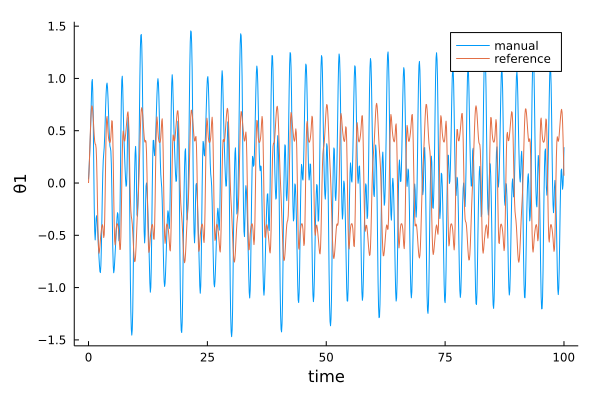

In [25]:
plot(time, z_[1,:], label="manual", ylabel="θ1")
plot!(time, sim_z[1,:], label="reference", xlabel="time")

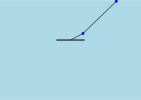

In [ ]:
for (ii,t) in enumerate(time)
    
    # Clear frame
    IJulia.clear_output(true)
    
    # Define mass size
    bob_size = 0.05
    
    # Extract Cartesian positions
    p1, p2 = polar2cart(z_[:,ii], l1=l1, l2=l2)

    nodes = []
    
    # root node: background
    push!(nodes, (context(units=UnitBox(-2, -2, 5, 5))), Compose.rectangle(), fill("lightblue"))
    
    # top line: ceiling
    push!(nodes, (context(), line([(0,0), (1,0)]), Compose.stroke("black"), linewidth(1mm)))

    for p in [p1, p2]
        
        # pendulum ball
        push!(nodes, (context(), Compose.circle(p[1], p[2], m1*bob_size), fill("blue")))
    end
    
    # pendulum thread
    push!(nodes, (context(), line([(0.5,0.0),(p1[1],p1[2])]), Compose.stroke("black"), linewidth(0.5mm)))
    push!(nodes, (context(), line([(p1[1],p1[2]),(p2[1],p2[2])]), Compose.stroke("black"), linewidth(0.5mm)))
    ctx = compose(nodes...)
    display(ctx)
    
end